In [386]:
import pandas as pd
import time
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, PolynomialFeatures
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression, RidgeClassifier, Lasso, Ridge
from sklearn.neighbors import KNeighborsClassifier
from sklearn.inspection import permutation_importance
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, accuracy_score
import re

In [387]:
all_teams_df = pd.read_csv('./Downloads/all_teams_full.csv')

In [388]:
all_teams_df.head()

,team,season,name,gameId,playerTeam,opposingTeam,home_or_away,gameDate,position,situation,...,unblockedShotAttemptsAgainst,scoreAdjustedUnblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,xGoalsFromxReboundsOfShotsAgainst,xGoalsFromActualReboundsOfShotsAgainst,reboundxGoalsAgainst,totalShotCreditAgainst,scoreAdjustedTotalShotCreditAgainst,scoreFlurryAdjustedTotalShotCreditAgainst,playoffGame
0,NYR,2008,NYR,2008020001,NYR,T.B,AWAY,20081004,Team Level,other,...,1.0,1.000,0.0,0.017,0.000,0.000,0.037,0.037,0.037,0
1,NYR,2008,NYR,2008020001,NYR,T.B,AWAY,20081004,Team Level,all,...,31.0,30.369,5.0,0.396,0.168,0.168,2.917,2.833,2.714,0
2,NYR,2008,NYR,2008020001,NYR,T.B,AWAY,20081004,Team Level,5on5,...,20.0,19.369,3.0,0.237,0.168,0.168,1.862,1.777,1.665,0
3,NYR,2008,NYR,2008020001,NYR,T.B,AWAY,20081004,Team Level,4on5,...,9.0,9.000,1.0,0.124,0.000,0.000,0.795,0.795,0.789,0
4,NYR,2008,NYR,2008020001,NYR,T.B,AWAY,20081004,Team Level,5on4,...,1.0,1.000,1.0,0.019,0.000,0.000,0.224,0.224,0.224,0


In [389]:
# filtering out playoff games and stats for particular game situations like PK or PP
regular_season_games=all_teams_df[(all_teams_df['playoffGame']==0) & (all_teams_df['situation']=='all')]

In [390]:
# removes adjusted or aggregated stats
column_names=regular_season_games.columns.tolist()

final_column_names=[]
for column_name in column_names:
    if 'adjust' not in column_name.lower() and not column_name.startswith('x') and 'xgoal' not in column_name.lower():
        final_column_names.append(column_name)
        
no_aggregate_fields=regular_season_games[final_column_names]

# remove position, playoffGame, situation, name, corsiPercentage, fenwickPercentage
no_aggregate_fields=no_aggregate_fields.drop(['position', 'playoffGame', 'situation', 'name', 'team', 'season', 'corsiPercentage', 'fenwickPercentage'], axis=1)
no_aggregate_fields.head()


,gameId,playerTeam,opposingTeam,home_or_away,gameDate,iceTime,shotsOnGoalFor,missedShotsFor,blockedShotAttemptsFor,shotAttemptsFor,...,giveawaysAgainst,lowDangerShotsAgainst,mediumDangerShotsAgainst,highDangerShotsAgainst,lowDangerGoalsAgainst,mediumDangerGoalsAgainst,highDangerGoalsAgainst,unblockedShotAttemptsAgainst,dZoneGiveawaysAgainst,totalShotCreditAgainst
1,2008020001,NYR,T.B,AWAY,20081004,3600.0,41.0,12.0,13.0,66.0,...,7.0,16.0,12.0,3.0,1.0,0.0,0.0,31.0,5.0,2.917
6,2008020003,NYR,T.B,HOME,20081005,3600.0,39.0,13.0,20.0,72.0,...,7.0,29.0,3.0,0.0,0.0,1.0,0.0,32.0,5.0,1.091
11,2008020010,NYR,CHI,HOME,20081010,3600.0,29.0,10.0,12.0,51.0,...,5.0,35.0,8.0,2.0,1.0,0.0,1.0,45.0,3.0,2.738
16,2008020019,NYR,PHI,AWAY,20081011,3600.0,27.0,11.0,12.0,50.0,...,8.0,27.0,11.0,3.0,2.0,0.0,1.0,41.0,4.0,3.123
21,2008020034,NYR,N.J,HOME,20081013,3600.0,24.0,8.0,13.0,45.0,...,3.0,28.0,5.0,6.0,0.0,0.0,1.0,39.0,3.0,2.698


In [391]:
# removes games that weren't completed or partially rescheduled (player health emergencies or other extenuating circumstances)
# also removes games that went to overtime to keep playtime consistent
completed_games=no_aggregate_fields[no_aggregate_fields['iceTime']==3600]

# drop iceTime
completed_games=completed_games.drop(['iceTime'], axis=1)

In [392]:
completed_games.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31264 entries, 1 to 217851
Data columns (total 61 columns):
 #   Column                             Non-Null Count  Dtype  
---  ------                             --------------  -----  
 0   gameId                             31264 non-null  int64  
 1   playerTeam                         31264 non-null  object 
 2   opposingTeam                       31264 non-null  object 
 3   home_or_away                       31264 non-null  object 
 4   gameDate                           31264 non-null  int64  
 5   shotsOnGoalFor                     31264 non-null  float64
 6   missedShotsFor                     31264 non-null  float64
 7   blockedShotAttemptsFor             31264 non-null  float64
 8   shotAttemptsFor                    31264 non-null  float64
 9   goalsFor                           31264 non-null  float64
 10  reboundsFor                        31264 non-null  float64
 11  reboundGoalsFor                    31264 non-null  float64

In [393]:
list(completed_games.columns)

['gameId',
 'playerTeam',
 'opposingTeam',
 'home_or_away',
 'gameDate',
 'shotsOnGoalFor',
 'missedShotsFor',
 'blockedShotAttemptsFor',
 'shotAttemptsFor',
 'goalsFor',
 'reboundsFor',
 'reboundGoalsFor',
 'freezeFor',
 'playStoppedFor',
 'playContinuedInZoneFor',
 'playContinuedOutsideZoneFor',
 'savedShotsOnGoalFor',
 'savedUnblockedShotAttemptsFor',
 'penaltiesFor',
 'penalityMinutesFor',
 'faceOffsWonFor',
 'hitsFor',
 'takeawaysFor',
 'giveawaysFor',
 'lowDangerShotsFor',
 'mediumDangerShotsFor',
 'highDangerShotsFor',
 'lowDangerGoalsFor',
 'mediumDangerGoalsFor',
 'highDangerGoalsFor',
 'unblockedShotAttemptsFor',
 'dZoneGiveawaysFor',
 'totalShotCreditFor',
 'shotsOnGoalAgainst',
 'missedShotsAgainst',
 'blockedShotAttemptsAgainst',
 'shotAttemptsAgainst',
 'goalsAgainst',
 'reboundsAgainst',
 'reboundGoalsAgainst',
 'freezeAgainst',
 'playStoppedAgainst',
 'playContinuedInZoneAgainst',
 'playContinuedOutsideZoneAgainst',
 'savedShotsOnGoalAgainst',
 'savedUnblockedShotAttemp

In [394]:
# No games will be ties because I omitted games that went to overtime
conditions = [
    (completed_games['goalsFor'] > completed_games['goalsAgainst']) & (completed_games['home_or_away']=='HOME'),
    (completed_games['goalsFor'] > completed_games['goalsAgainst']) & (completed_games['home_or_away']=='AWAY'),
    (completed_games['goalsFor'] < completed_games['goalsAgainst']) & (completed_games['home_or_away']=='HOME'),
    (completed_games['goalsFor'] < completed_games['goalsAgainst']) & (completed_games['home_or_away']=='AWAY'),

]
values = ['win', 'win', 'lose', 'lose']

# Create the new column using np.select()
completed_games['gameOutcome'] = np.select(conditions, values)

In [395]:
# each game contains stats from the perspectives of both the home and away team. Using only the "for" stats will avoid data duplication for each game
for_data_only = completed_games.drop(columns=[col for col in completed_games.columns if col.endswith("Against")])
final=for_data_only.drop(['gameId', 'playerTeam', 'opposingTeam'], axis=1)


In [396]:
final.info()


<class 'pandas.core.frame.DataFrame'>
Index: 31264 entries, 1 to 217851
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   home_or_away                   31264 non-null  object 
 1   gameDate                       31264 non-null  int64  
 2   shotsOnGoalFor                 31264 non-null  float64
 3   missedShotsFor                 31264 non-null  float64
 4   blockedShotAttemptsFor         31264 non-null  float64
 5   shotAttemptsFor                31264 non-null  float64
 6   goalsFor                       31264 non-null  float64
 7   reboundsFor                    31264 non-null  float64
 8   reboundGoalsFor                31264 non-null  float64
 9   freezeFor                      31264 non-null  float64
 10  playStoppedFor                 31264 non-null  float64
 11  playContinuedInZoneFor         31264 non-null  float64
 12  playContinuedOutsideZoneFor    31264 non-null  flo

In [397]:
final.sort_values(by='gameDate')
final['game_month'] = final['gameDate'].apply(lambda x: pd.to_datetime(str(x), format='%Y%m%d').month)


In [398]:
month_to_season = {
    10: "early_season", 11: "early_season", 12: "early_season",
     1: "mid_season",    2: "mid_season",
     3: "late_season",   4: "late_season",   5: "late_season"
}
# maps month to early, mid, late season distinction
final["season_phase"] = final["game_month"].map(month_to_season)


In [399]:
# drop date information now covered by season_phase column
final=final.drop(['gameDate', 'game_month'], axis=1)
final.info()

<class 'pandas.core.frame.DataFrame'>
Index: 31264 entries, 1 to 217851
Data columns (total 31 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   home_or_away                   31264 non-null  object 
 1   shotsOnGoalFor                 31264 non-null  float64
 2   missedShotsFor                 31264 non-null  float64
 3   blockedShotAttemptsFor         31264 non-null  float64
 4   shotAttemptsFor                31264 non-null  float64
 5   goalsFor                       31264 non-null  float64
 6   reboundsFor                    31264 non-null  float64
 7   reboundGoalsFor                31264 non-null  float64
 8   freezeFor                      31264 non-null  float64
 9   playStoppedFor                 31264 non-null  float64
 10  playContinuedInZoneFor         31264 non-null  float64
 11  playContinuedOutsideZoneFor    31264 non-null  float64
 12  savedShotsOnGoalFor            31264 non-null  flo

In [400]:
def get_bounds(all_column_data):
    Q1 = all_column_data.quantile(0.25)
    Q3 = all_column_data.quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    return upper_bound, lower_bound

In [401]:
# removes outliers from numeric fields
float_column_names = final.select_dtypes(include=np.float64).columns.values
print('final before: ', len(final))
for col in float_column_names:
    upper_bound, lower_bound = get_bounds(final[col])
    final = final[(final[col] >= lower_bound) & (final[col] <= upper_bound)]

print('final after: ', len(final))

final before:  31264
final after:  19782


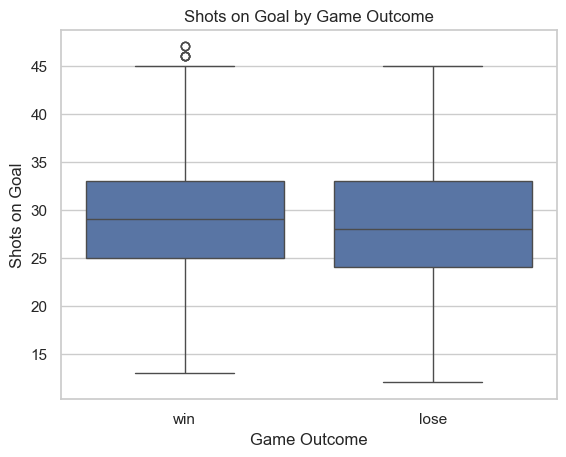

In [404]:
box = sns.boxplot(x='gameOutcome', y='shotsOnGoalFor', data=final)
plt.title('Shots on Goal by Game Outcome')
box.set_xlabel("Game Outcome")
box.set_ylabel("Shots on Goal")
plt.savefig('./shots_on_goal.png')
plt.show()


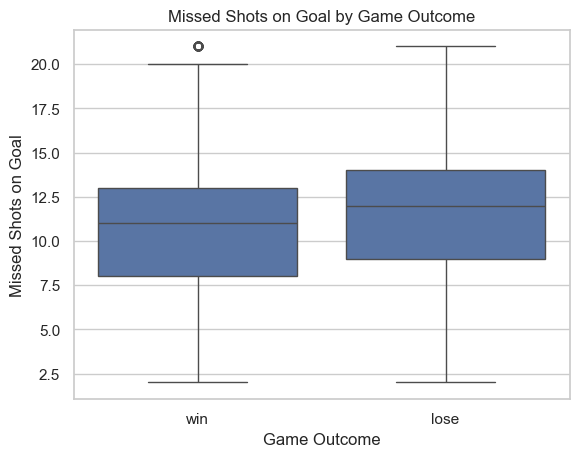

In [405]:
box = sns.boxplot(x='gameOutcome', y='missedShotsFor', data=final)
plt.title('Missed Shots on Goal by Game Outcome')
box.set_xlabel("Game Outcome")
box.set_ylabel("Missed Shots on Goal")
plt.savefig('./missed_shots_on_goal.png')
plt.show()
# conclusion: remove this column

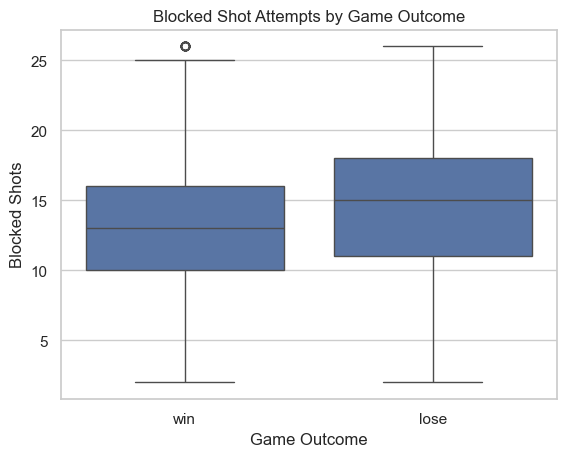

In [308]:
box = sns.boxplot(x='gameOutcome', y='blockedShotAttemptsFor', data=final)
plt.title('Blocked Shot Attempts by Game Outcome')
box.set_xlabel("Game Outcome")
box.set_ylabel("Blocked Shots")
plt.show()

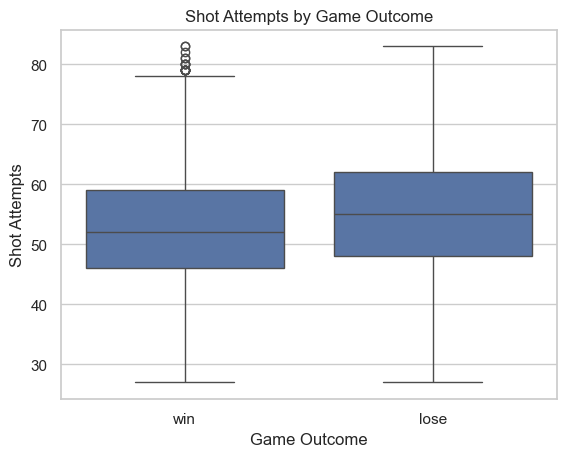

In [406]:
box = sns.boxplot(x='gameOutcome', y='shotAttemptsFor', data=final)
plt.title('Shot Attempts by Game Outcome')
box.set_xlabel("Game Outcome")
box.set_ylabel("Shot Attempts")
plt.savefig('./shot_attempts.png')

plt.show()

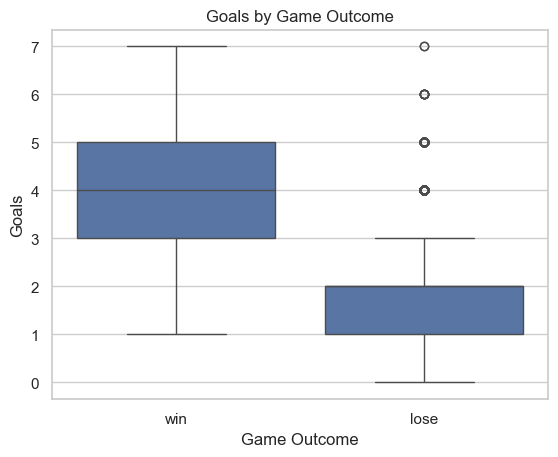

In [407]:
box = sns.boxplot(x='gameOutcome', y='goalsFor', data=final)
plt.title('Goals by Game Outcome')
box.set_xlabel("Game Outcome")
box.set_ylabel("Goals")
plt.savefig('./goals.png')
plt.show()

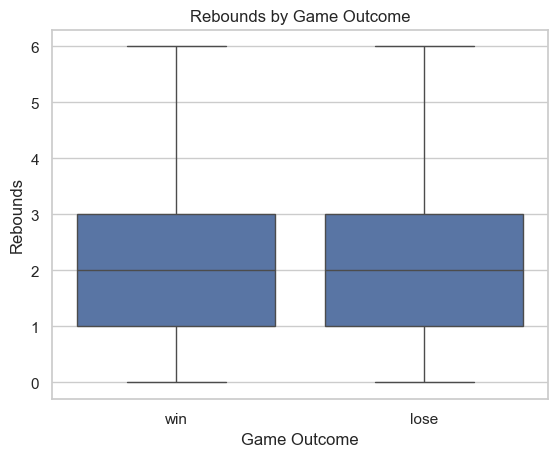

In [311]:
box = sns.boxplot(x='gameOutcome', y='reboundsFor', data=final)
plt.title('Rebounds by Game Outcome')
box.set_xlabel("Game Outcome")
box.set_ylabel("Rebounds")
plt.show()
# conclusion: remove this column

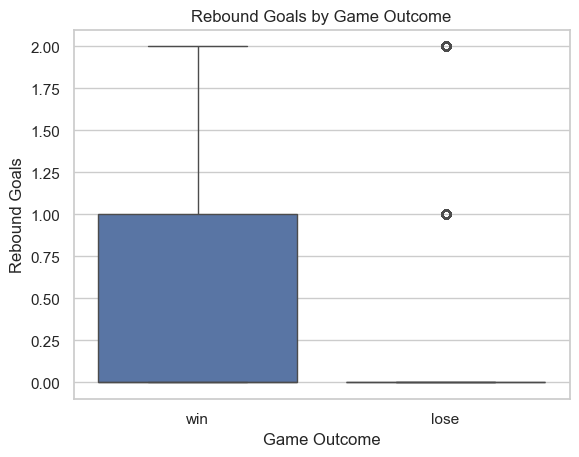

In [408]:
box = sns.boxplot(x='gameOutcome', y='reboundGoalsFor', data=final)
plt.title('Rebound Goals by Game Outcome')
box.set_xlabel("Game Outcome")
box.set_ylabel("Rebound Goals")
plt.savefig('./rebound_goals.png')

plt.show()

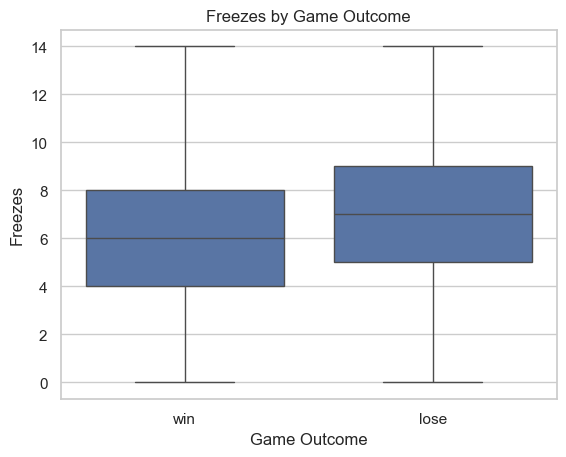

In [409]:
box = sns.boxplot(x='gameOutcome', y='freezeFor', data=final)
plt.title('Freezes by Game Outcome')
box.set_xlabel("Game Outcome")
box.set_ylabel("Freezes")
plt.savefig('./freezes.png')
plt.show()

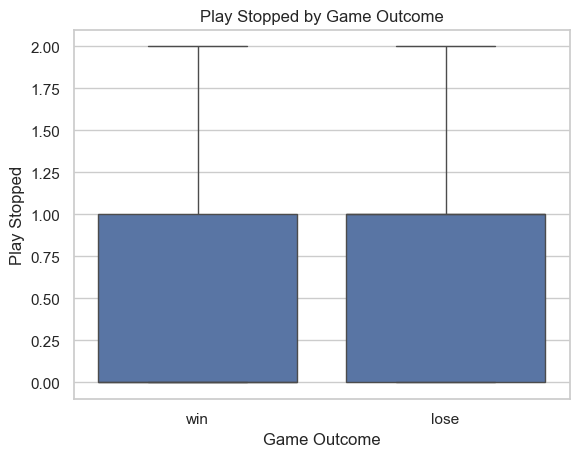

In [410]:
box = sns.boxplot(x='gameOutcome', y='playStoppedFor', data=final)
plt.title('Play Stopped by Game Outcome')
box.set_xlabel("Game Outcome")
box.set_ylabel("Play Stopped")
plt.savefig('./play_stopped.png')
plt.show()
# conclusion: Remove this

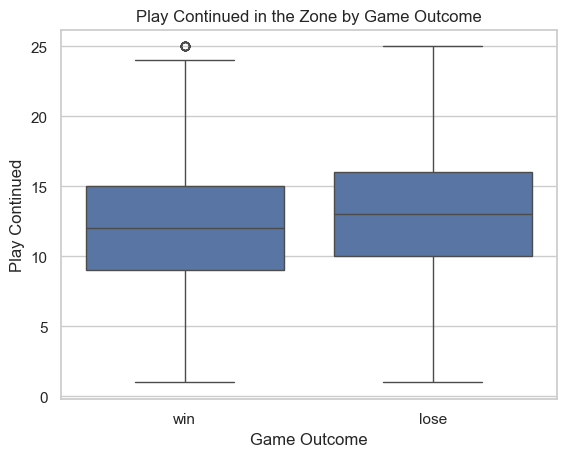

In [412]:
box = sns.boxplot(x='gameOutcome', y='playContinuedInZoneFor', data=final)
plt.title('Play Continued in the Zone by Game Outcome')
box.set_xlabel("Game Outcome")
box.set_ylabel("Play Continued")
plt.savefig('./play_continued_in_zone.png')
plt.show()

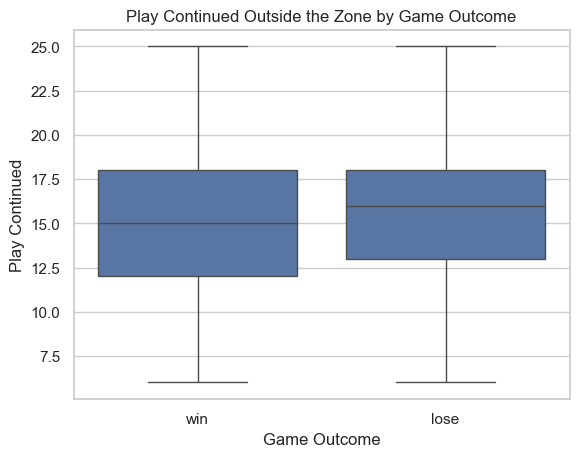

In [413]:
box = sns.boxplot(x='gameOutcome', y='playContinuedOutsideZoneFor', data=final)
plt.title('Play Continued Outside the Zone by Game Outcome')
box.set_xlabel("Game Outcome")
box.set_ylabel("Play Continued")
plt.savefig('./play_cont_outside_zone.png')
plt.show()

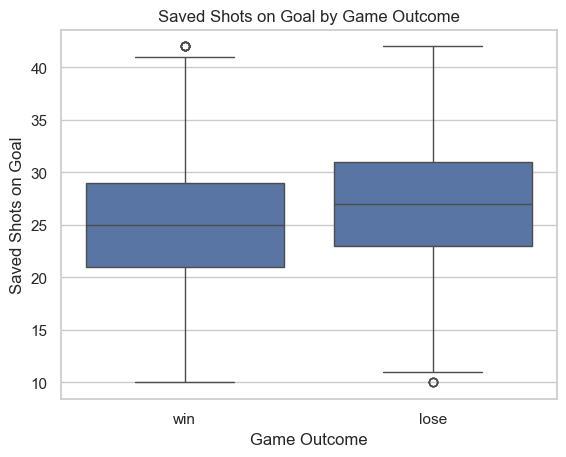

In [414]:
box = sns.boxplot(x='gameOutcome', y='savedShotsOnGoalFor', data=final)
plt.title('Saved Shots on Goal by Game Outcome')
box.set_xlabel("Game Outcome")
box.set_ylabel("Saved Shots on Goal")
plt.savefig('./saved_shots_on_goal.png')
plt.show()

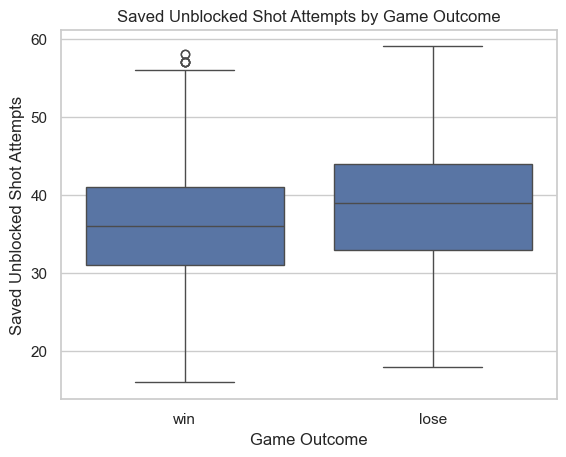

In [415]:
box = sns.boxplot(x='gameOutcome', y='savedUnblockedShotAttemptsFor', data=final)
plt.title('Saved Unblocked Shot Attempts by Game Outcome')
box.set_xlabel("Game Outcome")
box.set_ylabel("Saved Unblocked Shot Attempts")
plt.savefig('./saved_unblocked_shot_attempts.png')
plt.show()

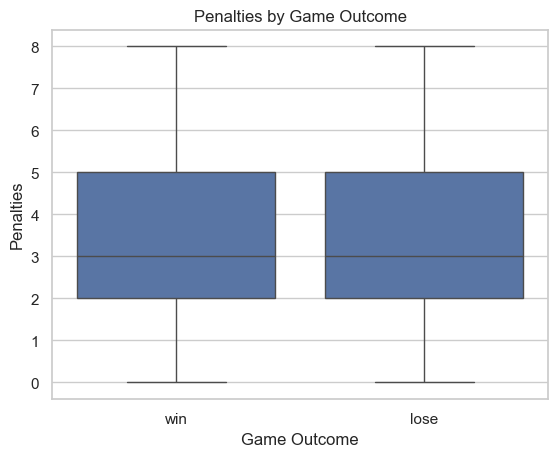

In [416]:
box = sns.boxplot(x='gameOutcome', y='penaltiesFor', data=final)
plt.title('Penalties by Game Outcome')
box.set_xlabel("Game Outcome")
box.set_ylabel("Penalties")
plt.savefig('./penalties.png')
plt.show()
# conclusion: remove this

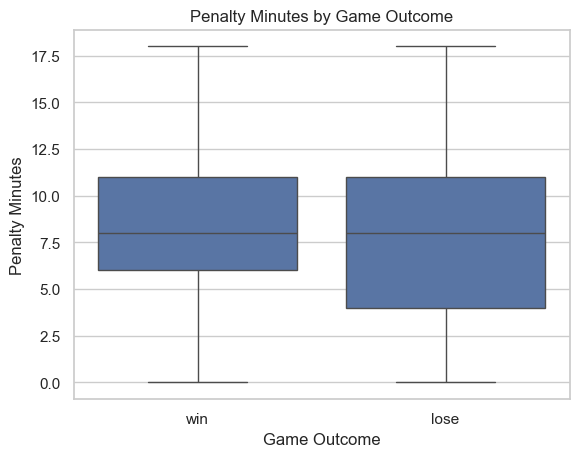

In [417]:
box = sns.boxplot(x='gameOutcome', y='penalityMinutesFor', data=final)
plt.title('Penalty Minutes by Game Outcome')
box.set_xlabel("Game Outcome")
box.set_ylabel("Penalty Minutes")
plt.savefig('./penalty_minutes.png')
plt.show()

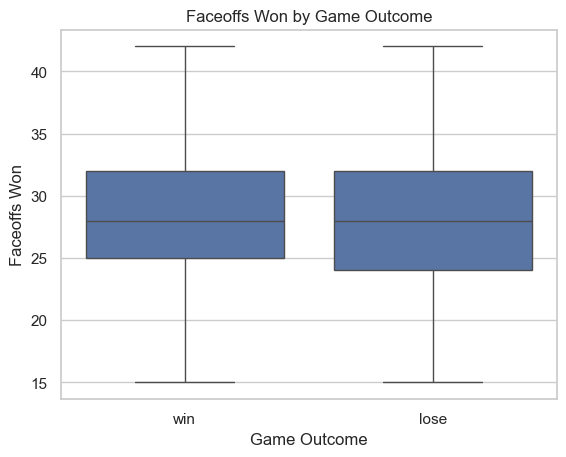

In [418]:
box = sns.boxplot(x='gameOutcome', y='faceOffsWonFor', data=final)
plt.title('Faceoffs Won by Game Outcome')
box.set_xlabel("Game Outcome")
box.set_ylabel("Faceoffs Won")
plt.savefig('./faceoffs_won.png')

plt.show()
# conclusion: remove this

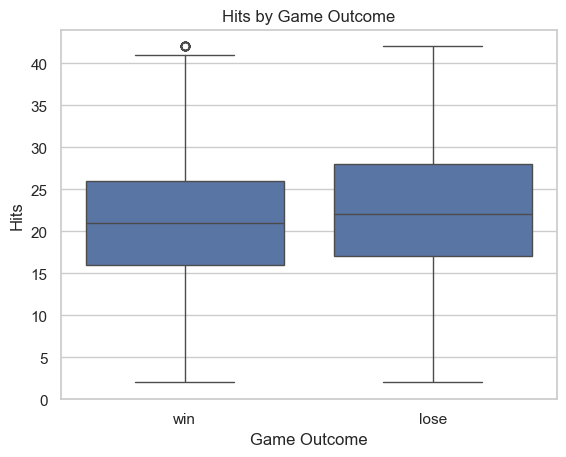

In [419]:
box = sns.boxplot(x='gameOutcome', y='hitsFor', data=final)
plt.title('Hits by Game Outcome')
box.set_xlabel("Game Outcome")
box.set_ylabel("Hits")
plt.savefig('./hits.png')

plt.show()

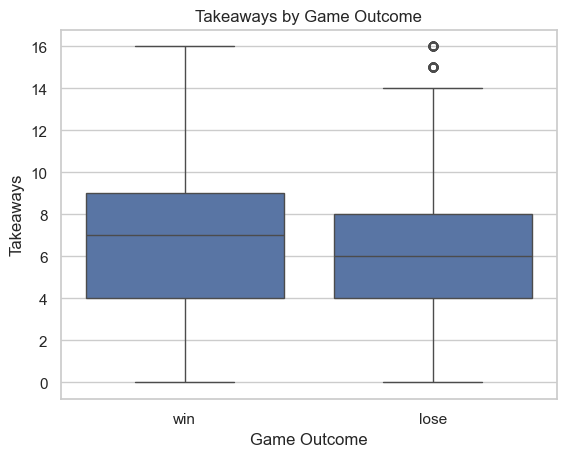

In [420]:
box = sns.boxplot(x='gameOutcome', y='takeawaysFor', data=final)
plt.title('Takeaways by Game Outcome')
box.set_xlabel("Game Outcome")
box.set_ylabel("Takeaways")
plt.savefig('./takeaways.png')
plt.show()

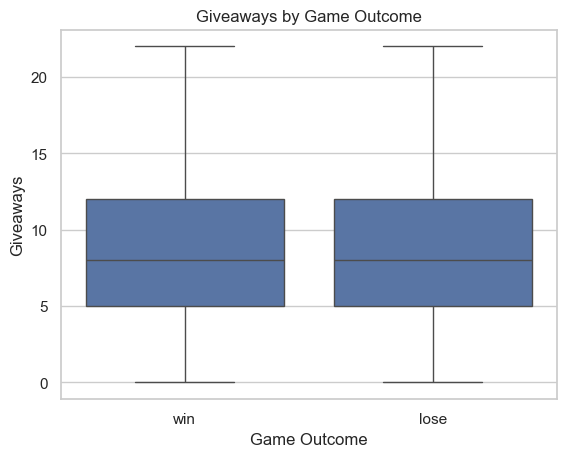

In [421]:
box = sns.boxplot(x='gameOutcome', y='giveawaysFor', data=final)
plt.title('Giveaways by Game Outcome')
box.set_xlabel("Game Outcome")
box.set_ylabel("Giveaways")
plt.savefig('./giveaways.png')

plt.show()
# conclusion: remove this

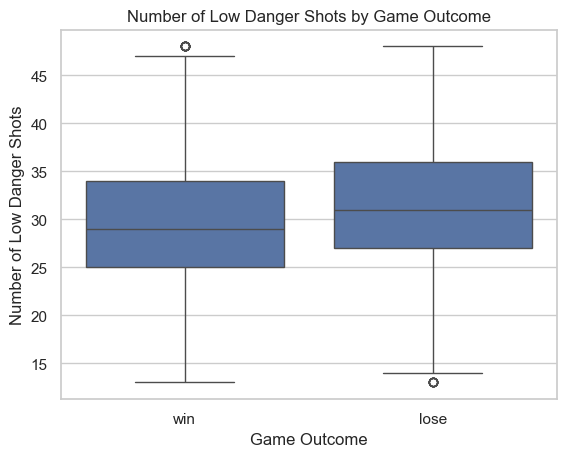

In [422]:
box = sns.boxplot(x='gameOutcome', y='lowDangerShotsFor', data=final)
plt.title('Number of Low Danger Shots by Game Outcome')
box.set_xlabel("Game Outcome")
box.set_ylabel("Number of Low Danger Shots")
plt.savefig('./num_low_danger_shots.png')

plt.show()

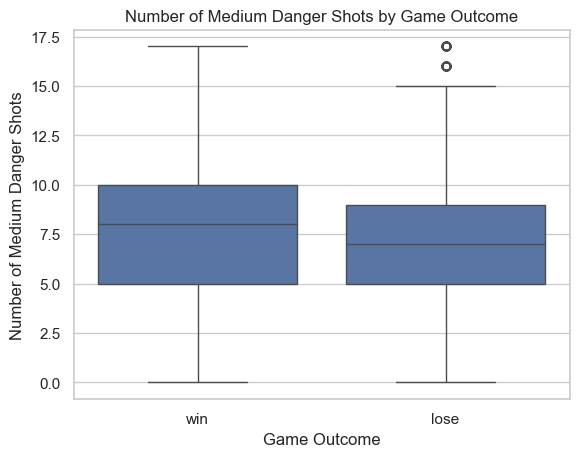

In [423]:
box = sns.boxplot(x='gameOutcome', y='mediumDangerShotsFor', data=final)
plt.title('Number of Medium Danger Shots by Game Outcome')
box.set_xlabel("Game Outcome")
box.set_ylabel("Number of Medium Danger Shots")
plt.savefig('./num_med_danger_shots.png')

plt.show()

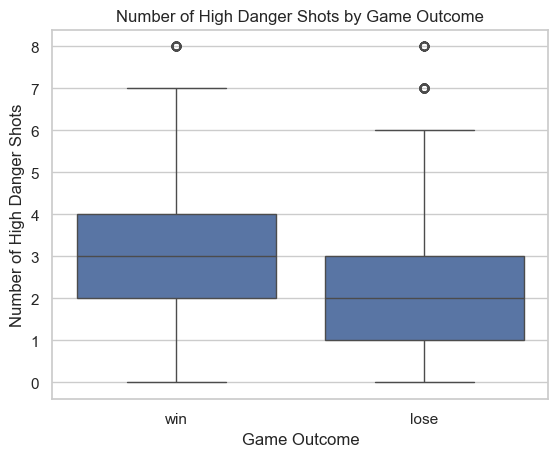

In [424]:
box = sns.boxplot(x='gameOutcome', y='highDangerShotsFor', data=final)
plt.title('Number of High Danger Shots by Game Outcome')
box.set_xlabel("Game Outcome")
box.set_ylabel("Number of High Danger Shots")
plt.savefig('./num_high_danger_shots.png')

plt.show()

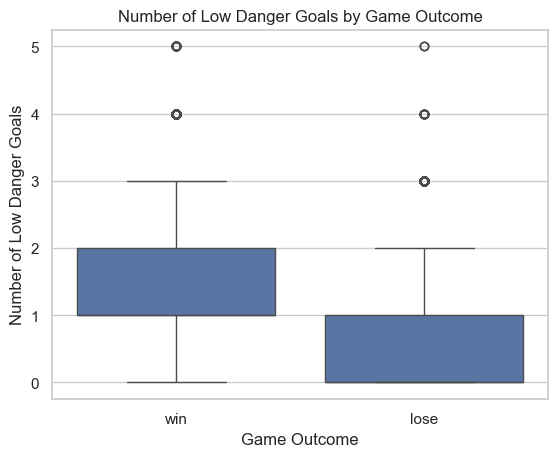

In [425]:
box = sns.boxplot(x='gameOutcome', y='lowDangerGoalsFor', data=final)
plt.title('Number of Low Danger Goals by Game Outcome')
box.set_xlabel("Game Outcome")
box.set_ylabel("Number of Low Danger Goals")
plt.savefig('./num_low_danger_goals.png')

plt.show()

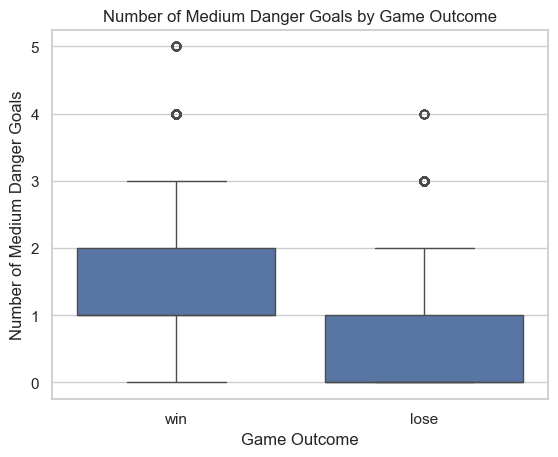

In [426]:
box = sns.boxplot(x='gameOutcome', y='mediumDangerGoalsFor', data=final)
plt.title('Number of Medium Danger Goals by Game Outcome')
box.set_xlabel("Game Outcome")
box.set_ylabel("Number of Medium Danger Goals")
plt.savefig('./num_med_danger_goals.png')

plt.show()

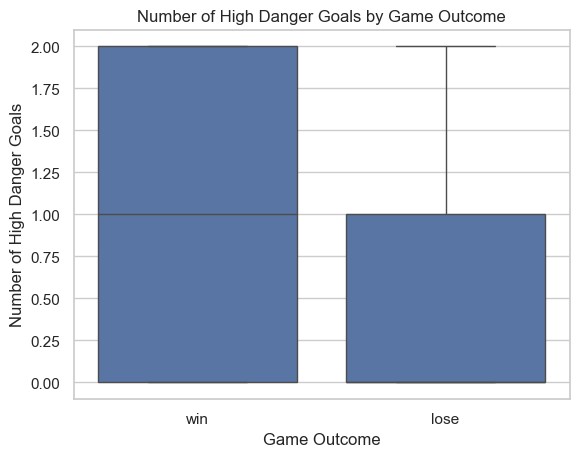

In [427]:
box = sns.boxplot(x='gameOutcome', y='highDangerGoalsFor', data=final)
plt.title('Number of High Danger Goals by Game Outcome')
box.set_xlabel("Game Outcome")
box.set_ylabel("Number of High Danger Goals")
plt.savefig('./num_high_danger_goals.png')

plt.show()

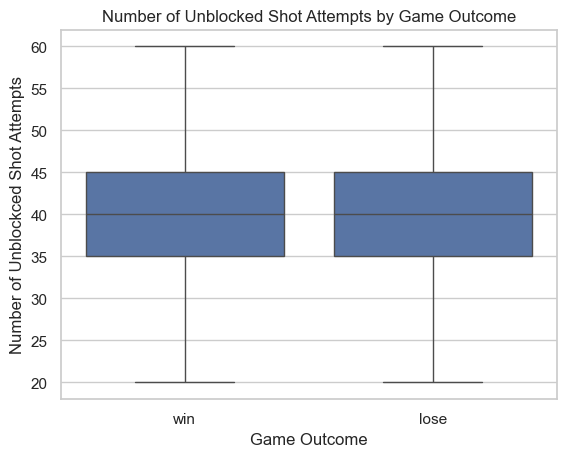

In [428]:
box = sns.boxplot(x='gameOutcome', y='unblockedShotAttemptsFor', data=final)
plt.title('Number of Unblocked Shot Attempts by Game Outcome')
box.set_xlabel("Game Outcome")
box.set_ylabel("Number of Unblockced Shot Attempts")
plt.savefig('./num_unblocked_shot_attempts.png')

plt.show()
# conclusion: remove this

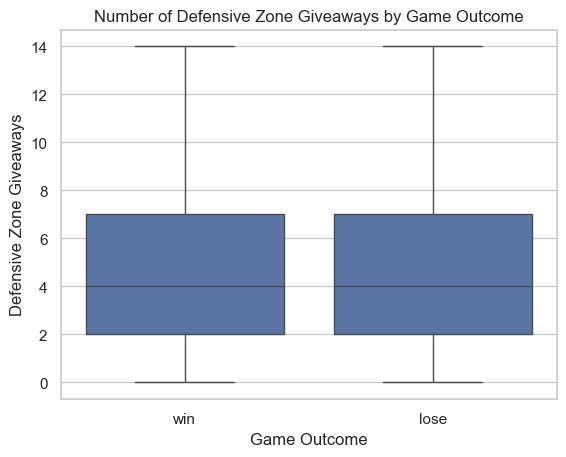

In [429]:
box = sns.boxplot(x='gameOutcome', y='dZoneGiveawaysFor', data=final)
plt.title('Number of Defensive Zone Giveaways by Game Outcome')
box.set_xlabel("Game Outcome")
box.set_ylabel("Defensive Zone Giveaways")
plt.savefig('./d_zone_giveaways.png')

plt.show()
# conclusion: remove this

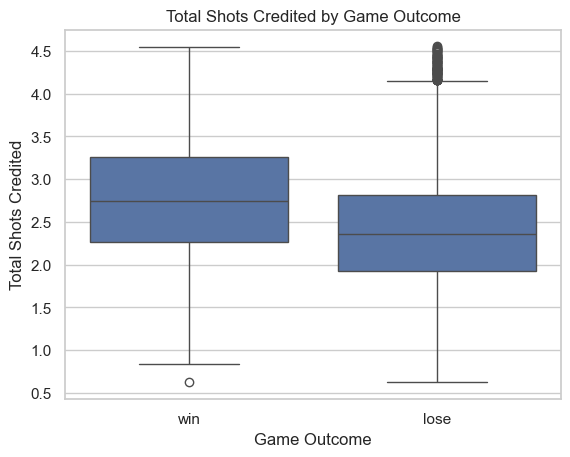

In [430]:
box = sns.boxplot(x='gameOutcome', y='totalShotCreditFor', data=final)
plt.title('Total Shots Credited by Game Outcome')
box.set_xlabel("Game Outcome")
box.set_ylabel("Total Shots Credited")
plt.savefig('./num_shots_credited.png')

plt.show()

In [431]:
# Remove the following fields based on their graphs: missedShotsFor, reboundsFor,
# playStoppedFor, penaltiesFor, faceOffsWonFor, giveawaysFor, unblockedShotAttemptsFor, dZoneGiveawaysFor
columns_to_drop=['missedShotsFor', 'reboundsFor', 'playStoppedFor', 'penaltiesFor', 'faceOffsWonFor', 'giveawaysFor', 'unblockedShotAttemptsFor', 'dZoneGiveawaysFor']
final_sanitized=final.drop(columns_to_drop, axis=1)
final_sanitized.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19782 entries, 6 to 217851
Data columns (total 23 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   home_or_away                   19782 non-null  object 
 1   shotsOnGoalFor                 19782 non-null  float64
 2   blockedShotAttemptsFor         19782 non-null  float64
 3   shotAttemptsFor                19782 non-null  float64
 4   goalsFor                       19782 non-null  float64
 5   reboundGoalsFor                19782 non-null  float64
 6   freezeFor                      19782 non-null  float64
 7   playContinuedInZoneFor         19782 non-null  float64
 8   playContinuedOutsideZoneFor    19782 non-null  float64
 9   savedShotsOnGoalFor            19782 non-null  float64
 10  savedUnblockedShotAttemptsFor  19782 non-null  float64
 11  penalityMinutesFor             19782 non-null  float64
 12  hitsFor                        19782 non-null  flo

In [432]:
X = final_sanitized.drop('gameOutcome', axis=1)
y = final_sanitized.gameOutcome


In [433]:
X.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19782 entries, 6 to 217851
Data columns (total 22 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   home_or_away                   19782 non-null  object 
 1   shotsOnGoalFor                 19782 non-null  float64
 2   blockedShotAttemptsFor         19782 non-null  float64
 3   shotAttemptsFor                19782 non-null  float64
 4   goalsFor                       19782 non-null  float64
 5   reboundGoalsFor                19782 non-null  float64
 6   freezeFor                      19782 non-null  float64
 7   playContinuedInZoneFor         19782 non-null  float64
 8   playContinuedOutsideZoneFor    19782 non-null  float64
 9   savedShotsOnGoalFor            19782 non-null  float64
 10  savedUnblockedShotAttemptsFor  19782 non-null  float64
 11  penalityMinutesFor             19782 non-null  float64
 12  hitsFor                        19782 non-null  flo

In [434]:
# Prepare features and target column for modeling
le = LabelEncoder()
y = le.fit_transform(y)
categorical_columns = X.select_dtypes(include=['object']).columns.tolist()
numerical_columns = X.select_dtypes(include=['float64']).columns.tolist()


In [435]:
# Encodes the categorical data and standardizes numerical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_columns),
        ('cat', OneHotEncoder(drop='first'), categorical_columns)
    ]
)

In [436]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)


In [437]:
# Use logistic regression
# Create a pipeline
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=1000))
])

param_grid = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs', 'liblinear']
}

# Perform grid search with 5-fold cross validation
grid_search = GridSearchCV(pipeline, param_grid=param_grid, cv=5, n_jobs=-1, scoring="accuracy")
grid_search.fit(X_train, y_train)


print("Best parameters:", grid_search.best_params_)
print("Best cross-validated accuracy:", grid_search.best_score_)


Best parameters: {'classifier__C': 0.1, 'classifier__penalty': 'l2', 'classifier__solver': 'lbfgs'}
Best cross-validated accuracy: 0.8312281017401268


In [438]:
# Get the best estimator
best_model = grid_search.best_estimator_

# Evaluate on training and test sets
train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)
print('train_score: ', train_score)
print('test_score: ', test_score)

train_score:  0.8316602874268795
test_score:  0.8306655433866892


In [439]:
# Find out which features were most relevant to the best model
feature_names = best_model.named_steps['preprocessor'].get_feature_names_out()

# Get model coefficients
coefs = best_model.named_steps['classifier'].coef_[0]

coef_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs
}).sort_values(by='coefficient', ascending=False)
print(coef_df)

                               feature  coefficient
3                        num__goalsFor     1.021917
19             num__totalShotCreditFor     0.707898
17           num__mediumDangerGoalsFor     0.705151
16              num__lowDangerGoalsFor     0.604919
18             num__highDangerGoalsFor     0.485569
20              cat__home_or_away_HOME     0.475423
12                   num__takeawaysFor     0.154706
13              num__lowDangerShotsFor     0.143382
0                  num__shotsOnGoalFor     0.126306
22        cat__season_phase_mid_season     0.073502
4                 num__reboundGoalsFor     0.048118
15             num__highDangerShotsFor    -0.053792
11                        num__hitsFor    -0.078827
7     num__playContinuedOutsideZoneFor    -0.089103
21       cat__season_phase_late_season    -0.111099
2                 num__shotAttemptsFor    -0.122521
10             num__penalityMinutesFor    -0.138285
8             num__savedShotsOnGoalFor    -0.158333
5           

In [440]:
# KNN
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('knn', KNeighborsClassifier())
])

# Perform grid search with 5-fold cross validation and a variety of hyperparameters
grid_search = GridSearchCV(pipeline, param_grid={'knn__n_neighbors': [3, 5, 7]}, cv=5, n_jobs=-1, scoring="accuracy")

# Fit the model and time it
grid_search.fit(X_train, y_train)

best_model = grid_search.best_estimator_

result = permutation_importance(
    best_model,
    X_test,
    y_test,
    n_repeats=20,
    random_state=42,
    scoring='accuracy'
)
preprocessor = best_model.named_steps['preprocessor']
feature_names = X_train.columns

importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance_mean': result.importances_mean,
    'importance_std': result.importances_std
}).sort_values(by='importance_mean', ascending=False)

print(importance_df)
train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)
print('train_score: ', train_score)
print('test_score: ', test_score)

                          feature  importance_mean  importance_std
4                        goalsFor         0.067388        0.004520
17              lowDangerGoalsFor         0.037254        0.004478
18           mediumDangerGoalsFor         0.028374        0.003472
19             highDangerGoalsFor         0.014473        0.002469
20             totalShotCreditFor         0.011390        0.002421
2          blockedShotAttemptsFor         0.004414        0.003273
10  savedUnblockedShotAttemptsFor         0.004187        0.002149
9             savedShotsOnGoalFor         0.003783        0.003113
8     playContinuedOutsideZoneFor         0.002595        0.002048
1                  shotsOnGoalFor         0.002468        0.001924
7          playContinuedInZoneFor         0.002435        0.002442
3                 shotAttemptsFor         0.002098        0.002572
6                       freezeFor         0.002081        0.002968
11             penalityMinutesFor         0.001516        0.00

In [441]:
# Decision Tree Classifier
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('decisiontreeclassifier', DecisionTreeClassifier())
])

# Perform grid search with 5-fold cross validation and a variety of hyperparameters
grid_search = GridSearchCV(pipeline, param_grid={'decisiontreeclassifier__max_depth': [2, 5, 7]}, cv=5, n_jobs=-1, scoring="accuracy")

grid_search.fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Evaluate on training and test sets
train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)
print('train_score', train_score)
print('test_score', test_score)


train_score 0.8276160901278256
test_score 0.8197135636057288


In [442]:
# SVC
pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('svc', SVC())
])

# Perform grid search with 5-fold cross validation and a variety of hyperparameters
grid_search = GridSearchCV(pipeline, param_grid={'svc__C': [0.1, 1, 10], 'svc__kernel': ['linear', 'rbf']}, cv=5, n_jobs=-1, scoring="accuracy")

# Fit the model and time it
grid_search.fit(X_train, y_train)

# Get the best estimator
best_model = grid_search.best_estimator_

# Evaluate on training and test sets
train_score = best_model.score(X_train, y_train)
test_score = best_model.score(X_test, y_test)
print('train_score', train_score)
print('test_score', test_score)


train_score 0.8381598902289304
test_score 0.8323504633529908


In [443]:
preprocessor = ColumnTransformer([
    ('num', Pipeline([
        ('poly', PolynomialFeatures(degree=2, include_bias=False)),
        ('scaler', StandardScaler())
    ]), numerical_columns),
    ('cat', OneHotEncoder(drop='first'), categorical_columns)
])

pipeline = Pipeline([
    ('preprocessor', preprocessor),
    ('lasso_clf', LogisticRegression(penalty='l1', solver='liblinear', C=1.0))
])

pipeline.fit(X_train, y_train)
accuracy = pipeline.score(X_test, y_test)
print("Test set accuracy:", accuracy)

feature_names = pipeline.named_steps['preprocessor'].get_feature_names_out()
coefs = pipeline.named_steps['lasso_clf'].coef_[0]

importance_df = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs
}).sort_values(by='coefficient', ascending=False)
print(importance_df)

Test set accuracy: 0.8333614153327716
                                            feature  coefficient
3                                     num__goalsFor     2.076119
229                       num__totalShotCreditFor^2     1.128747
204       num__lowDangerShotsFor highDangerShotsFor     0.695452
230                          cat__home_or_away_HOME     0.497494
226    num__mediumDangerGoalsFor totalShotCreditFor     0.383712
..                                              ...          ...
50              num__blockedShotAttemptsFor hitsFor    -0.392159
14                        num__mediumDangerShotsFor    -0.422839
6                       num__playContinuedInZoneFor    -0.443531
134  num__playContinuedInZoneFor highDangerShotsFor    -0.470425
208       num__lowDangerShotsFor totalShotCreditFor    -0.538282

[233 rows x 2 columns]


In [444]:
importance_df_abs = pd.DataFrame({
    'feature': feature_names,
    'coefficient': coefs
}).sort_values(by='coefficient', key=abs, ascending=False)
print(importance_df_abs.head(20))

                                               feature  coefficient
3                                        num__goalsFor     2.076119
229                          num__totalShotCreditFor^2     1.128747
204          num__lowDangerShotsFor highDangerShotsFor     0.695452
208          num__lowDangerShotsFor totalShotCreditFor    -0.538282
230                             cat__home_or_away_HOME     0.497494
134     num__playContinuedInZoneFor highDangerShotsFor    -0.470425
6                          num__playContinuedInZoneFor    -0.443531
14                           num__mediumDangerShotsFor    -0.422839
50                 num__blockedShotAttemptsFor hitsFor    -0.392159
226       num__mediumDangerGoalsFor totalShotCreditFor     0.383712
19                             num__totalShotCreditFor     0.363435
163        num__savedShotsOnGoalFor totalShotCreditFor    -0.336796
77                                     num__goalsFor^2    -0.328293
126  num__playContinuedInZoneFor playContinuedOu

In [445]:
# create categorical column based on quarterile
def add_quartile_category(df, column):
    # Compute quartiles
    quartiles = pd.qcut(df[column], q=4, labels=False, duplicates='drop')
    # Map to labels
    labels = ["q1", "q2", "q3", "q4"]
    df[f"{column}_cat"] = quartiles.map(lambda x: labels[int(x)])
    return df.drop(columns=[column])

In [446]:
final_cat=X.copy(deep=True) 
for col in numerical_columns:
    final_cat=add_quartile_category(final_cat, col)
final_cat.info()

<class 'pandas.core.frame.DataFrame'>
Index: 19782 entries, 6 to 217851
Data columns (total 22 columns):
 #   Column                             Non-Null Count  Dtype 
---  ------                             --------------  ----- 
 0   home_or_away                       19782 non-null  object
 1   season_phase                       19782 non-null  object
 2   shotsOnGoalFor_cat                 19782 non-null  object
 3   blockedShotAttemptsFor_cat         19782 non-null  object
 4   shotAttemptsFor_cat                19782 non-null  object
 5   goalsFor_cat                       19782 non-null  object
 6   reboundGoalsFor_cat                19782 non-null  object
 7   freezeFor_cat                      19782 non-null  object
 8   playContinuedInZoneFor_cat         19782 non-null  object
 9   playContinuedOutsideZoneFor_cat    19782 non-null  object
 10  savedShotsOnGoalFor_cat            19782 non-null  object
 11  savedUnblockedShotAttemptsFor_cat  19782 non-null  object
 12  penality

In [447]:
X_train_cat, X_test_cat, y_train_cat, y_test_cat = train_test_split(final_cat, y, test_size=0.3, random_state=42)


In [448]:
categorical_features_cat = final_cat.select_dtypes(include=['object']).columns.tolist()
preprocessor_cat = ColumnTransformer([
    ('cat', OneHotEncoder(drop='first'), categorical_features_cat)
])


In [449]:
# Use logistic regression on categories
# Create a pipeline
pipeline_cat = Pipeline([
    ('preprocessor', preprocessor_cat),
    ('classifier', LogisticRegression(max_iter=1000))
])

param_grid_cat = {
    'classifier__C': [0.01, 0.1, 1, 10, 100],
    'classifier__penalty': ['l2'],
    'classifier__solver': ['lbfgs', 'liblinear']
}

# Perform grid search with 5-fold cross validation
grid_search_cat = GridSearchCV(pipeline_cat, param_grid=param_grid_cat, cv=5, n_jobs=-1, scoring="accuracy")
grid_search_cat.fit(X_train_cat, y_train_cat)


print("Best parameters:", grid_search_cat.best_params_)
print("Best cross-validated accuracy:", grid_search_cat.best_score_)

Best parameters: {'classifier__C': 100, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best cross-validated accuracy: 0.8123064667743571


In [450]:
best_model_cat = grid_search_cat.best_estimator_

# Evaluate on training and test sets
train_score_cat = best_model_cat.score(X_train_cat, y_train_cat)
test_score_cat = best_model_cat.score(X_test_cat, y_test_cat)
print('train_score_cat: ', train_score_cat)
print('test_score_cat: ', test_score_cat)

# Find out which features were most relevant to the best model
feature_names_cat = best_model_cat.named_steps['preprocessor'].get_feature_names_out()

# Get model coefficients
coefs_cat = best_model_cat.named_steps['classifier'].coef_[0]

coef_df_cat = pd.DataFrame({
    'feature': feature_names_cat,
    'coefficient': coefs_cat
}).sort_values(by='coefficient', ascending=False)
print(coef_df_cat)

train_score_cat:  0.8146891023326353
test_score_cat:  0.8077506318449874
                                      feature  coefficient
14                       cat__goalsFor_cat_q4     4.749865
13                       cat__goalsFor_cat_q3     3.703921
12                       cat__goalsFor_cat_q2     2.169296
56             cat__totalShotCreditFor_cat_q4     1.488970
52           cat__mediumDangerGoalsFor_cat_q3     0.833821
5                  cat__shotsOnGoalFor_cat_q4     0.820631
55             cat__totalShotCreditFor_cat_q3     0.794523
0                      cat__home_or_away_HOME     0.483988
51           cat__mediumDangerGoalsFor_cat_q2     0.472198
4                  cat__shotsOnGoalFor_cat_q3     0.472168
53             cat__highDangerGoalsFor_cat_q2     0.461315
49              cat__lowDangerGoalsFor_cat_q2     0.439530
39                   cat__takeawaysFor_cat_q4     0.419780
50              cat__lowDangerGoalsFor_cat_q3     0.412997
42              cat__lowDangerShotsFor_cat